In [11]:
import pandas as pd
import geopandas as gpd
import ast
%matplotlib inline

def get_kommune(kommune_string):
    res = ast.literal_eval(kommune_string)
    return res[0]['navn']

#test_string = '[ { "rekkefolge": "", "sprak": "nor", "navn": "Vadsø" } ]'
#get_kommune(test_string)

To install geopandas on Windows you need to do this:
```
pip install wheel
pip install pipwin
pipwin install gdal
pipwin install fiona
pip install geopandas
```

In [12]:
# df_places = gpd.read_file('kommuner_komprimert.json')
df_places = gpd.read_file('kommuner_komprimert.json')[['kommunenummer', 'navn', 'geometry']]
df_places['navn'] = df_places['navn'].apply(lambda x: get_kommune(x))
df_places.rename(columns = {'navn': 'kommune'}, inplace = True)
df_places.head()
#df_places.info()
#df_places[df_places['geometry'].isnull()]

,kommunenummer,kommune,geometry
0,5405,Vadsø,"POLYGON ((28.98103 70.40655, 29.05203 70.40828..."
1,4625,Austevoll,"POLYGON ((4.54705 60.10405, 5.05288 60.14941, ..."
2,1848,Steigen,"POLYGON ((14.12563 67.94409, 14.78371 68.05597..."
3,1845,Sørfold,"POLYGON ((15.07389 67.61695, 15.11372 67.63029..."
4,5404,Vardø,"POLYGON ((31.22260 70.64439, 31.54880 70.54528..."


<AxesSubplot:>

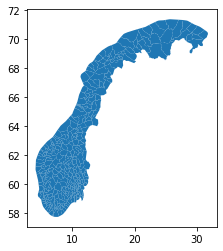

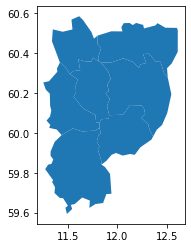

In [13]:
df_places.plot()

eidskog_neighbours = [
    'Eidskog',
    'Kongsvinger',
    'Grue',
    'Aurskog-Høland',
    'Sør-Odal',
    'Nord-Odal',
    'Nes'
]

filtered_df = df_places[df_places.kommune.isin(eidskog_neighbours)]
#filtered_df = df_places
filtered_df.head()
filtered_df.plot()
# Plot Eidskog
#df_places['geometry'][96]

Nå kommer innlesing av tall fra MSIS:

In [14]:
msis_df = pd.read_csv('2021-04-02.Tilfeller-etter-sykdom-fordelt-på-geografi-2021.csv', sep = ';', skiprows = 1)
new_column_names = {'Unnamed: 0': 'kommune',
                    'Koronavirus med utbruddspotensial, Mars': 'Mars',
                    'Koronavirus med utbruddspotensial, Januar': 'Januar',
                    'Koronavirus med utbruddspotensial, Februar': 'Februar'}
msis_df.rename(columns = new_column_names, inplace = True)
msis_df.head()

,kommune,Mars,Januar,Februar
0,Aurskog-Høland,99,26,26
1,Eidskog,6,23,2
2,Grue,18,15,2
3,Kongsvinger,35,28,11
4,Nes,181,79,56


In [15]:
merged = filtered_df.merge(msis_df, left_on='kommune', right_on='kommune')
merged.head()

,kommunenummer,kommune,geometry,Mars,Januar,Februar
0,3416,Eidskog,"POLYGON ((11.81939 60.02363, 11.82226 60.05214...",6,23,2
1,3415,Sør-Odal,"POLYGON ((11.52034 60.29543, 11.55999 60.30950...",9,15,7
2,3401,Kongsvinger,"POLYGON ((11.83072 60.35413, 11.93127 60.35099...",35,28,11
3,3417,Grue,"POLYGON ((11.79917 60.48677, 11.93833 60.50863...",18,15,2
4,3414,Nord-Odal,"POLYGON ((11.34226 60.45880, 11.35089 60.51826...",14,5,6


Convert to GeoJSON:

In [16]:
import json

#Read data to json.
merged_json = json.loads(merged.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

Render our choropleth map using Bokeh:

In [17]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import brewer

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)

#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]

#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 40)

#Define custom tick labels for color bar.
tick_labels = {'0': '0', '5': '5', '10':'10', '15':'15', '20':'20', '25':'25', '30':'30','35':'35', '40': '>40'}

#Add hover tool
hover = HoverTool(tooltips = [ ('Kommune','@kommune'),('Smittede', '@Mars')])

#Create color bar.
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = 'Koronasmitte i kommunene rundt Eidskog, mars 2021', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure.
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Mars', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

Loading BokehJS ...